# VPIC simulation

## Simulation deck

For the current run (`sigmae100_bg00_400de`), we will use the machine Perlmutter@NERSC as an example. There are many files in the run directory. Below is a list of important ones for this tutorial.
- `check_energies.py`: python script to check the energy conservation.
- `compile_deck.sh`: bash script to compile the deck.
- `Makefile_*`: GNU Makefile for different systems.
- `perlmutter.batch`: Slurm script to submit jobs on Perlmutter
- `tracer.hh`: header file for tracking tracer particles
- `reconnection.cc`: the main deck file. It includes the following code for different functionalities.
    - `dumptracer_hdf5_single.cc`: code to dump tracer particles
    - `dump_with_h5part.cc`: code to dump particle data
    - `energy_local.cc`: code to get local energy spectra and particle distributions in different energy bands
    - `open_boundary.cc`: code for performing open-boundary simulations.
    - `time_average_master.cc`: code to do time average as the simulations are running.
    - `species_advance/`: directory including test-particle code
- `vpic`: modified script for compiling the deck. It includes code in `species_advance/` for test particles.

## Simulation parameters

This 2D simulation is performed in the $x-z$ plane. We use a forcefree current sheet, which has a magnetic profile
$
\boldsymbol{B}=B_0\tanh(z/\lambda)\hat{x} + B_0\text{sech}(z/\lambda)\hat{y},
$
where $\lambda$ is the half thickness of the current sheet. The electron magnetization parameter $\sigma_e=(\Omega_{ce}/\omega_{pe})^2=B_0^2/4\pi n_0m_e^2=100$. The plasma consists of electron-positron pairs with mass ratio $m_i/m_e=1$.

Others may define a magnetization parameter $\sigma=B_0^2/4\pi nm_e^2$ for pair plasmas, where $n=2n_0$ is the total number density of electrons and positrons. In that case, $\sigma=50$ here.

The box sizes are $L_x=400d_e$ and $L_z=200d_e$, where $d_e=c/\omega_{pe}$ is the electron inertial length. The initial distributions are relativistic Maxwellian (or [Maxwell–Jüttner distribution](https://en.wikipedia.org/wiki/Maxwell%E2%80%93J%C3%BCttner_distribution)), with a uniform density $n_0$ and temperature $T_e=T_i=0.36m_ec^2$. The grid sizes are $n_x\times n_z=4096\times2048$. We will use `nppc=100`, which is the number of pairs in each cell. We will select a subset of particles (1 of 3000) to trace their trajectories at every time step. In total, about 280k pairs will be traced.


## Compile and run

We will use compiled VPIC with HDF5 in `$CFS/m2407/xiaocanli/vpic_hdf5_rebase`. To compile the deck,
```sh
./compile_dech.sh
```
which will generate the executable `reconnection.Linux` and the output directories. Then, we can request 4 interactive nodes to run the simulation.
```sh
salloc --nodes 4 --qos interactive --time 04:00:00 --constraint cpu --account=m2407
module load cpu cray-hdf5-parallel
```
Alternatively, we can submit a batch job.
```sh
sbatch perlmutter.batch
```
The simulation will take about one hour to finish. The primary output data includes the following.
- `info`: simulation parameters, such as plasma parameters and system sizes. These are useful for data analysis.
- `field_hdf5`: field data in HDF5 format.
- `hydro_hdf5`: hydro data in HDF5 format. These are the moments of the particle distributions.
- `spectrum`: particle spectrum data.
- `tracer`: particle tracer data.
- `rundata/energies`: time evolution of the energies (electric, magnetic, and kinetic)

The rest are created for binary output, which is not used in this tutorial. For detailed description of the output files, see [HDF5_version_of_VPIC.md](https://github.com/xiaocanli/vpic_reconnection_tutorial/blob/main/HDF5_version_of_VPIC.md). Note that [quick_check_vpic](https://github.com/xiaocanli/quick_check_vpic) is a good way to look into the data quickly. For detailed analysis, we will use the following scripts.

In [1]:
import errno
import math
import json
import os
import random
import sys

import h5py
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
# import palettable
from matplotlib import rc
from matplotlib.colors import LogNorm
# from astropy.modeling import models, fitting
# from scipy.constants import physical_constants
# from scipy.interpolate import interp1d
# from scipy.ndimage import median_filter, gaussian_filter
# from scipy.optimize import curve_fit
# from scipy import special
# from scipy.special import kn, kv
# from scipy import integrate
# from lmfit import Minimizer, Parameter, Parameters, report_fit
# from tqdm import tqdm
from matplotlib import gridspec
from matplotlib.collections import LineCollection
# from scipy.interpolate import interp1d

plt.rcParams['figure.dpi'] = 200

# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"

In [2]:
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise
            
def get_vpic_info():
    """Get information of the VPIC simulation
    """
    with open('./info') as f:
        content = f.readlines()
    f.close()
    vpic_info = {}
    for line in content[1:]:
        if "=" in line:
            line_splits = line.split("=")
        elif ":" in line:
            line_splits = line.split(":")

        tail = line_splits[1].split("\n")
        vpic_info[line_splits[0].strip()] = float(tail[0])
    return vpic_info

In [3]:
vpic_info = get_vpic_info()
print(vpic_info)

{'sigma': 100.0, 'L/di': 6.0, 'L/de': 6.0, 'rhoi/L': 0.1178511, 'Ti/Te': 1.0, 'Tbe/Te': 1.0, 'Tbi/Ti': 1.0, 'Te': 0.36, 'Ti': 0.36, 'nb/n0': 1.0, 'wpe/wce': 0.1, 'factor': 6.0, 'mi/me': 1.0, 'theta': 0.0, 'taui': 8000.0, 'num_step': 12872.0, 'Lx/de': 400.0, 'Ly/de': 0.09765625, 'Lz/de': 200.0, 'Lx/di': 400.0, 'Ly/di': 0.09765625, 'Lz/di': 200.0, 'nx': 4096.0, 'ny': 1.0, 'nz': 2048.0, 'courant': 0.9, 'nproc': 512.0, 'nppc': 100.0, 'b0': 10.0, 'v_A (based on nb)': 10.0, 'di': 1.0, 'Ne': 838860800.0, 'total # of particles': 1677722000.0, 'qi': 9.313226e-06, 'qe': -9.313226e-06, 'nfac': 0.01, 'dt*wpe': 0.06214806, 'dt*wce': 0.6214806, 'dt*wci': 0.6214806, 'energies_interval': 100.0, 'dx/de': 0.09765625, 'dy/de': 0.09765625, 'dz/de': 0.09765625, 'dx/rhoe': 1.627604, 'L/debye': 10.0, 'dx/rhoi': 1.627604, 'dx/debye': 0.1627604, 'n0': 1.0, 'vthi/c': 0.6, 'vthe/c': 0.6, 'vthib/c': 0.6, 'vtheb/c': 0.6, 'restart_interval': 160906.0, 'spectrum_interval': 1609.0, 'fields_interval': 1609.0, 'ehydro_

# Energy evolution
Here, we plot the time evolution of the different energies and check the energy convservation of the simulation.

Total energy: 1.000129


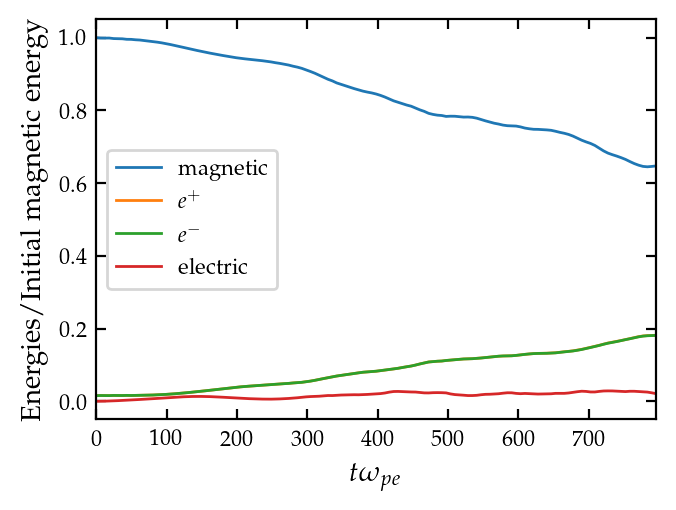

In [4]:
fdata = np.genfromtxt("rundata/energies", skip_header=3)
twpe = fdata[:, 0] * vpic_info["dt*wpe"]
ene_electric = np.sum(fdata[:, 1:4], axis=1)
ene_magnetic = np.sum(fdata[:, 4:7], axis=1)
ene_ion = fdata[:, 7]
ene_electron = fdata[:, 8]
ene_tot = np.sum(fdata[:, 1:], axis=1)

e0 = ene_magnetic[0]  # Using the initial magnetic energy for normalization

ene_electric /= e0
ene_magnetic /= e0
ene_ion /= e0
ene_electron /= e0

print("Total energy: %f" % (ene_tot[-1]/ene_tot[0]))

rect = [0.16, 0.16, 0.8, 0.8]
fig1 = plt.figure(figsize=[3.5, 2.5])
ax1 = fig1.add_axes(rect)

ax1.plot(twpe, ene_magnetic, linewidth=1, label="magnetic")
ax1.plot(twpe, ene_ion, linewidth=1, label=r"$e^+$")
ax1.plot(twpe, ene_electron, linewidth=1, label=r"$e^-$")
ax1.plot(twpe, ene_electric, linewidth=1, label="electric")

ax1.set_xlim([0, twpe[-1]])

ax1.tick_params(bottom=True, top=True, left=True, right=True)
ax1.tick_params(axis='x', which='minor', direction='in')
ax1.tick_params(axis='x', which='major', direction='in')
ax1.tick_params(axis='y', which='minor', direction='in')
ax1.tick_params(axis='y', which='major', direction='in')
ax1.set_xlabel(r'$t\omega_{pe}$', fontsize=10)
ax1.set_ylabel('Energies/Initial magnetic energy', fontsize=10)
ax1.tick_params(labelsize=8)

ax1.legend(loc=6, prop={'size': 8}, ncol=1,
           shadow=False, fancybox=True, frameon=True)

img_dir = './img/'
mkdir_p(img_dir)
fname = img_dir + "enes.pdf"
fig1.savefig(fname)

# Reconnection rate
Here, we check the reconnection rate. We need to the out-of-plane component of the vector potential $A_y$ to calculate the rate. To calculate $A_y$, we need to use a Fortran program `ay_gda_hdf5.f90` in the run directory. We need to compile it first and then run it. Typically, we need to modify `it1`, `it2`, `interval`, `nx`, `nz`, `xmax`, `zmax`. For the tutorial, you can use the default values.
```sh
module load cpu cray-fftw cray-hdf5
ftn -o ay_gda_hdf5 ay_gda_hdf5.f90
./ay_gda_hdf5
```
which will produce `Ay.gda` file in the `data/` directory. It is binary file including $A_y$ from all time frames. $A_y$ will also be used to plot the magnetic field lines.

In [5]:
def calc_reconnection_rate():
    """Calculate reconnection rate.
    """
    fname = 'data/Ay.gda'
    nx = int(vpic_info["nx"])
    nz = int(vpic_info["nz"])
    ntf = int(os.path.getsize(fname) / (nx * nz * 4))
    phi = np.zeros(ntf)
    for tframe in range(ntf):
        Ay = np.fromfile(fname, offset=tframe*nx*nz*4, count=nx*nz, dtype=np.float32).reshape([nz, nx])
        max_ay = np.max(np.mean(Ay[nz // 2 - 1:nz // 2 + 1, :], axis=0))
        min_ay = np.min(np.mean(Ay[nz // 2 - 1:nz // 2 + 1, :], axis=0))
        phi[tframe] = max_ay - min_ay
    dtf_wpe = vpic_info["fields_interval"] * vpic_info["dt*wpe"]
    rrate = np.zeros(ntf)
    rrate[1:] = np.diff(phi) / dtf_wpe
    b0 = vpic_info["b0"]
    sigmae = vpic_info["sigma"]
    va = math.sqrt(sigmae / (sigmae + 1.0))  # relativistic version of the Alfven speed
    rrate /= b0 * va
    tfields = np.arange(ntf) * dtf_wpe
    tfields[1:] = 0.5 * (tfields[1:] + tfields[:-1])

    return (tfields, rrate)

In [6]:
tfields, rrate = calc_reconnection_rate()

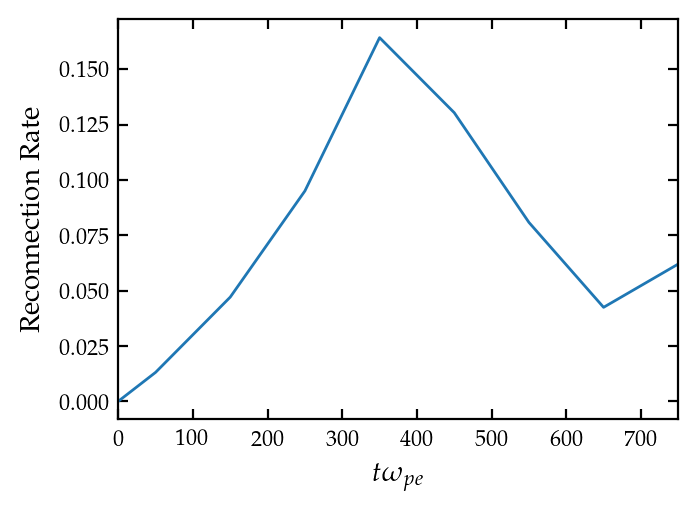

In [7]:
rect = [0.16, 0.16, 0.8, 0.8]
fig1 = plt.figure(figsize=[3.5, 2.5])
ax1 = fig1.add_axes(rect)

ax1.plot(tfields, rrate, linewidth=1)

ax1.set_xlim([0, tfields[-1]])

ax1.tick_params(bottom=True, top=True, left=True, right=True)
ax1.tick_params(axis='x', which='minor', direction='in')
ax1.tick_params(axis='x', which='major', direction='in')
ax1.tick_params(axis='y', which='minor', direction='in')
ax1.tick_params(axis='y', which='major', direction='in')
ax1.set_xlabel(r'$t\omega_{pe}$', fontsize=10)
ax1.set_ylabel('Reconnection Rate', fontsize=10)
ax1.tick_params(labelsize=8)
img_dir = './img/'
mkdir_p(img_dir)
fname = img_dir + "rrate.pdf"
fig1.savefig(fname)

Since we only have a few frames, the curve does not look very nice. However, we can see that the peak of the reconnection rate is over 0.1, which is consistent with earlier studies.

# 2D plots

We need to the out-of-plane component of the vector potential $A_y$ if we want to plot the magnetic field lines nicely. Otherwise, we can use `streamplot` in `matplotlib`.

In [8]:
fields_list = ["cbx", "cby", "cbz", "absb",  # magnetic field
               "ex", "ey", "ez"]  # electric field
jlist = ["jx", "jy", "jz", "absj"]  # current density
ehydro_list = [
    "ne", "vex", "vey", "vez",  # number density, three-velocity
    "uex", "uey", "uez",  # four-velocity
    "pexx", "pexy", "pexz",  # pressure tensor
    "peyx", "peyy", "peyz",
    "pezx", "pezy", "pezz"
]
Hhydro_list = [
    "ni", "vix", "viy", "viz",
    "uix", "uiy", "uiz",
    "pixx", "pixy", "pixz",
    "piyx", "piyy", "piyz",
    "pizx", "pizy", "pizz"
]
hydro_list = jlist + ehydro_list + Hhydro_list

In [9]:
# Functions to read the data
def read_fields(vname, tindex):
    """read electric and magnetic fields in HDF5 format

    Args:
        vname (string): variable name
        tindex (int): time index
    """
    fdir = "./field_hdf5/T." + str(tindex) + "/"
    fname = fdir + "fields_" + str(tindex) + ".h5"
    with h5py.File(fname, 'r') as fh:
        group = fh["Timestep_" + str(tindex)]
        if vname == "absb":
            bvec = {}
            for var in ["cbx", "cby", "cbz"]:
                dset = group[var]
                bvec[var] = dset[:, 0, :]
            field_2d = np.sqrt(bvec["cbx"]**2 + bvec["cby"]**2 +
                               bvec["cbz"]**2)
        else:
            dset = group[vname]
            field_2d = dset[:, 0, :]
    return field_2d

def read_current_density_species(vname, tindex, species):
    """read current density associated with one species

    Args:
        vname (string): variable name
        tindex (int): time index
        species (string): particle species
    """
    fdir = "./hydro_hdf5/T." + str(tindex) + "/"
    fname = fdir + "hydro_" + species + "_" + str(tindex) + ".h5"
    j2d = {}
    with h5py.File(fname, 'r') as fh:
        group = fh["Timestep_" + str(tindex)]
        if vname == "absj":
            for var in ["jx", "jy", "jz"]:
                dset = group[var]
                j2d[var] = dset[:, 0, :]
        else:
            dset = group[vname]
            j2d["jdir"] = dset[:, 0, :]
    return j2d

def read_current_density(vname, tindex):
    """read current density

    Args:
        vname (string): variable name
        tindex (int): time index
    """
    # Electron
    j2d = read_current_density_species(vname, tindex, "electron")

    # Ion
    jtmp = read_current_density_species(vname, tindex, "ion")
    for var in j2d:
        j2d[var] += jtmp[var]

    if vname == "absj":
        field_2d = np.sqrt(j2d["jx"]**2 + j2d["jy"]**2 + j2d["jz"]**2)
    else:
        field_2d = j2d["jdir"]

    return field_2d

def read_hydro_species(vname, tindex, species):
    """Read the hydro data of one species

    Args:
        vname (string): variable name
        tindex (int): time index
        species (string): particle species
    """
    fdir = "./hydro_hdf5/T." + str(tindex) + "/"
    fname = fdir + "hydro_" + species + "_" + str(tindex) + ".h5"

    hydro = {}
    keys = []
    with h5py.File(fname, 'r') as fh:
        group = fh["Timestep_" + str(tindex)]
        if vname[0] == "n":
            keys.append("rho")
        elif vname[0] == 'v':  # for velocity
            keys.append("rho")
            keys.append("j" + vname[-1])
        elif vname[0] == 'u':  # for four-velocity
            keys.append("rho")
            keys.append("p" + vname[-1])
        else:  # for pressure tensor
            keys.append("rho")
            keys.append("j" + vname[-2])
            keys.append("p" + vname[-1])
            vtmp = "t" + vname[2:]
            if vtmp in group:
                keys.append(vtmp)
            else:
                keys.append("t" + vname[-1] + vname[-2])
        for key in keys:
            dset = group[key]
            hydro[key] = dset[:, 0, :]
    return hydro

def read_hydro(vname, tindex):
    """Read hydro data from file

    Args:
        vname (string): variable name
        tindex (int): time index
    """
    if vname in ehydro_list:
        hydro = read_hydro_species(vname, tindex, "electron")
    else:
        hydro = read_hydro_species(vname, tindex, "ion")

    if vname[0] == 'n':  # number density
        field_2d = np.abs(hydro["rho"])
    elif vname[0] == 'v':  # velocity
        field_2d = hydro["j" + vname[-1]] / hydro["rho"]
    elif vname[0] == 'u':  # four-velocity
        field_2d = hydro["p" + vname[-1]] / (pmass * np.abs(hydro["rho"]))
    else:  # pressure tensor
        vtmp = "t" + vname[2:]
        if vtmp in hydro:
            tvar = vtmp
        else:
            tvar = "t" + vname[-1] + vname[-2]
        jvar = "j" + vname[-2]
        pvar = "p" + vname[-1]
        field_2d = hydro[tvar] - (hydro[jvar] / hydro["rho"]) * hydro[pvar]
    return field_2d

def read_data(vname, tindex):
    """Read data from file

    Args:
        vname (string): variable name
        tindex (int): time index
    """
    if vname in fields_list:  # electric and magnetic fields
        field_2d = read_fields(vname, tindex)
    elif vname in jlist:  # current density
        field_2d = read_current_density(vname, tindex)
    else:  # density, velocity, momentum, pressure tensor
        field_2d = read_hydro(vname, tindex)
        
    return field_2d

## Current density
Here, we plot the current density at three time frames to show the time evolution of the system.

In [10]:
def plot_absj_tri(show_plot=True):
    """Plot current density at three time frames
    """
    tframes = [0, 4, 8]
    fig = plt.figure(figsize=[3.5, 5.0])
    gs = gridspec.GridSpec(3,
                           1,
                           wspace=0,
                           hspace=0,
                           top=0.96,
                           bottom=0.08,
                           left=0.16,
                           right=0.97)

    nframes = len(tframes)

    fields_interval = int(vpic_info["fields_interval"])
    nx = int(vpic_info["nx"])
    nz = int(vpic_info["nz"])
    xmin = 0
    xmax = vpic_info["Lx/de"]
    zmin = -0.5 * vpic_info["Lz/de"]
    zmax = 0.5 * vpic_info["Lz/de"]
    xgrid = np.linspace(xmin, xmax, nx+1)
    zgrid = np.linspace(zmin, zmax, nz+1)
    xcell = 0.5 * (xgrid[:-1] + xgrid[1:])
    zcell = 0.5 * (zgrid[:-1] + zgrid[1:])
    axs = []    
    
    for iframe, tframe in enumerate(tframes):
        tindex = fields_interval * tframe
        absj = read_data("absj", tindex)
        ax = plt.subplot(gs[iframe, 0])
        axs.append(ax)
        im1 = ax.imshow(absj.T,
                        extent=[xmin, xmax, zmin, zmax],
                        norm = LogNorm(vmin=0.1, vmax=10),
                        cmap=plt.cm.viridis, aspect='auto',
                        origin='lower',
                        interpolation='none')
        # plot magnetic field lines using Ay
        Ay = np.fromfile("data/Ay.gda", offset=tframe*nx*nz*4, count=nx*nz, dtype=np.float32).reshape([nz, nx])
        ax.contour(xcell, zcell, Ay, colors='black', linewidths=0.5)
        if iframe == nframes - 1:
            ax.set_xlabel(r'$x/d_e$', fontsize=10)
        else:
            ax.tick_params(axis='x', labelbottom=False)
        ax.set_ylabel(r'$z/d_e$', fontsize=10)
        twpe = math.ceil(tindex * vpic_info["dt*wpe"] / 0.1) * 0.1
        text1 = r'$t\omega_{pe}=' + ("{%0.0f}" % twpe) + '$'
        ax.text(0.03, 0.9, text1, color='w', fontsize=10,
                bbox=dict(facecolor='none', alpha=1.0, edgecolor='none', pad=10.0),
                horizontalalignment='left', verticalalignment='center',
                transform=ax.transAxes)
        # ax.tick_params(labelsize=12)
        # ax.set_ylim([-500, 500])
    for ax in axs:
        ax.set_yticks([-50, 0, 50])
        ax.tick_params(bottom=True, top=True, left=True, right=True)
        ax.tick_params(axis='x', which='minor', direction='in')
        ax.tick_params(axis='x', which='major', direction='in')
        ax.tick_params(axis='y', which='minor', direction='in')
        ax.tick_params(axis='y', which='major', direction='in')
        ax.tick_params(labelsize=8)
    pos1 = np.asarray(axs[0].get_position()).flatten()
    rect = [pos1[0], pos1[1], pos1[2] - pos1[0], pos1[3] - pos1[1]]
    rect_cbar = np.copy(rect)
    rect_cbar[0] += rect[2] - 0.13
    rect_cbar[2] = 0.03
    rect_cbar[1] += rect[3] * 0.05
    rect_cbar[3] = rect[3] * 0.8
    cbar_ax = fig.add_axes(rect_cbar)
    cbar = fig.colorbar(im1, cax=cbar_ax, extend='both')
    cbar_ax.tick_params(bottom=False, top=False, left=False, right=True)
    cbar_ax.tick_params(axis='y', which='major', direction='out')
    cbar_ax.tick_params(axis='y', which='minor', direction='in', right=False)
    cbar_ax.set_title(r'$|\boldsymbol{J}|$', color='w', fontsize=10)
    cbar.ax.tick_params(labelsize=8, color='w')
    cbar.ax.yaxis.set_tick_params(color='w')
    cbar.outline.set_edgecolor('w')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='w')
    img_dir = './img/'
    mkdir_p(img_dir)
    fname = img_dir + "absj_tri.pdf"
    fig.savefig(fname, dpi=200)

    if show_plot:
        plt.show()
    else:
        plt.close()

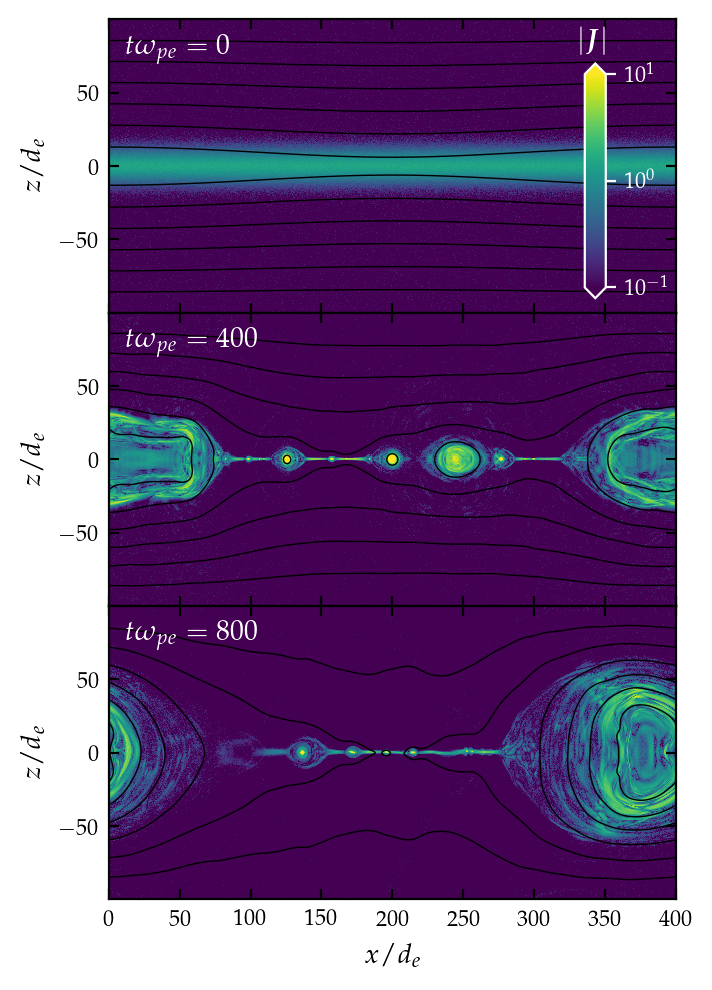

In [11]:
plot_absj_tri(show_plot=True)

## Plasma density

In [12]:
def plot_ne_tri(show_plot=True):
    """Plot electron number density at three time frames
    """
    tframes = [0, 4, 8]
    fig = plt.figure(figsize=[3.5, 5.0])
    gs = gridspec.GridSpec(3,
                           1,
                           wspace=0,
                           hspace=0,
                           top=0.96,
                           bottom=0.08,
                           left=0.16,
                           right=0.97)

    nframes = len(tframes)

    fields_interval = int(vpic_info["fields_interval"])
    nx = int(vpic_info["nx"])
    nz = int(vpic_info["nz"])
    xmin = 0
    xmax = vpic_info["Lx/de"]
    zmin = -0.5 * vpic_info["Lz/de"]
    zmax = 0.5 * vpic_info["Lz/de"]
    xgrid = np.linspace(xmin, xmax, nx+1)
    zgrid = np.linspace(zmin, zmax, nz+1)
    xcell = 0.5 * (xgrid[:-1] + xgrid[1:])
    zcell = 0.5 * (zgrid[:-1] + zgrid[1:])
    axs = []    
    
    for iframe, tframe in enumerate(tframes):
        tindex = fields_interval * tframe
        absj = read_data("ne", tindex)
        ax = plt.subplot(gs[iframe, 0])
        axs.append(ax)
        im1 = ax.imshow(absj.T,
                        extent=[xmin, xmax, zmin, zmax],
                        norm = LogNorm(vmin=0.1, vmax=10),
                        cmap=plt.cm.plasma, aspect='auto',
                        origin='lower',
                        interpolation='none')
        # plot magnetic field lines using Ay
        Ay = np.fromfile("data/Ay.gda", offset=tframe*nx*nz*4, count=nx*nz, dtype=np.float32).reshape([nz, nx])
        ax.contour(xcell, zcell, Ay, colors='black', linewidths=0.5)
        if iframe == nframes - 1:
            ax.set_xlabel(r'$x/d_e$', fontsize=10)
        else:
            ax.tick_params(axis='x', labelbottom=False)
        ax.set_ylabel(r'$z/d_e$', fontsize=10)
        twpe = math.ceil(tindex * vpic_info["dt*wpe"] / 0.1) * 0.1
        text1 = r'$t\omega_{pe}=' + ("{%0.0f}" % twpe) + '$'
        ax.text(0.03, 0.9, text1, color='w', fontsize=10,
                bbox=dict(facecolor='none', alpha=1.0, edgecolor='none', pad=10.0),
                horizontalalignment='left', verticalalignment='center',
                transform=ax.transAxes)
        # ax.tick_params(labelsize=12)
        # ax.set_ylim([-500, 500])
    for ax in axs:
        ax.set_yticks([-50, 0, 50])
        ax.tick_params(bottom=True, top=True, left=True, right=True)
        ax.tick_params(axis='x', which='minor', direction='in')
        ax.tick_params(axis='x', which='major', direction='in')
        ax.tick_params(axis='y', which='minor', direction='in')
        ax.tick_params(axis='y', which='major', direction='in')
        ax.tick_params(labelsize=8)
    pos1 = np.asarray(axs[0].get_position()).flatten()
    rect = [pos1[0], pos1[1], pos1[2] - pos1[0], pos1[3] - pos1[1]]
    rect_cbar = np.copy(rect)
    rect_cbar[0] += rect[2] - 0.13
    rect_cbar[2] = 0.03
    rect_cbar[1] += rect[3] * 0.05
    rect_cbar[3] = rect[3] * 0.8
    cbar_ax = fig.add_axes(rect_cbar)
    cbar = fig.colorbar(im1, cax=cbar_ax, extend='both')
    cbar_ax.tick_params(bottom=False, top=False, left=False, right=True)
    cbar_ax.tick_params(axis='y', which='major', direction='out')
    cbar_ax.tick_params(axis='y', which='minor', direction='in', right=False)
    cbar_ax.set_title(r'$n_e$', color='w', fontsize=10)
    cbar.ax.tick_params(labelsize=8, color='w')
    cbar.ax.yaxis.set_tick_params(color='w')
    cbar.outline.set_edgecolor('w')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='w')
    img_dir = './img/'
    mkdir_p(img_dir)
    fname = img_dir + "ne_tri.pdf"
    fig.savefig(fname, dpi=200)

    if show_plot:
        plt.show()
    else:
        plt.close()

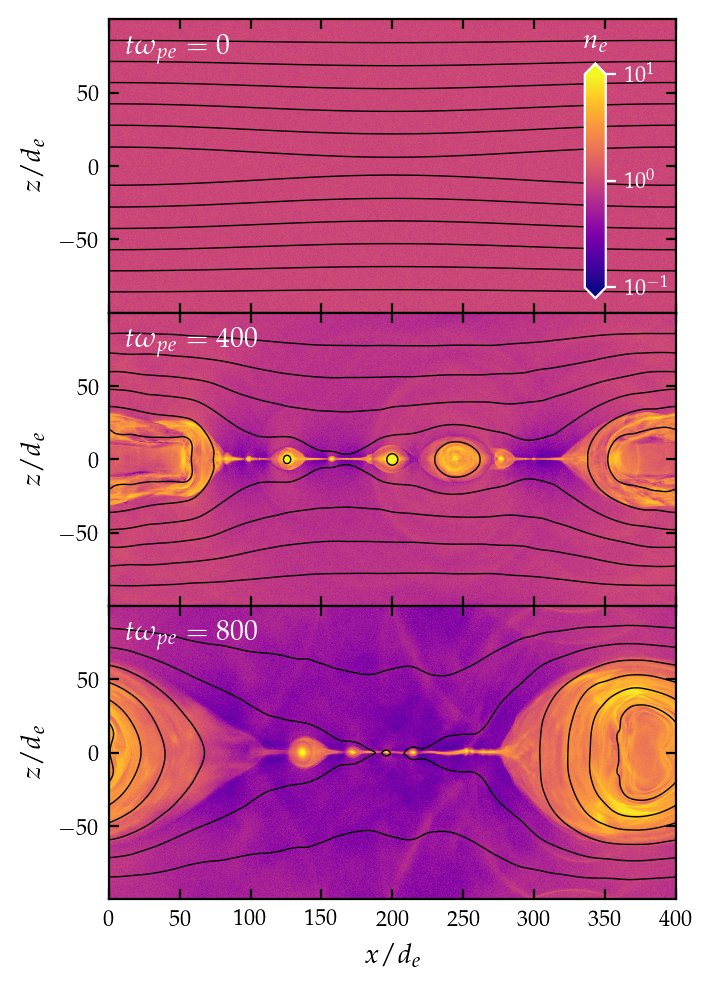

In [13]:
plot_ne_tri(show_plot=True)

## Electric fields
Here, we plot the $z$-component of the ideal electric field $\boldsymbol{E}_I=-\boldsymbol{v}\times\boldsymbol{B}$, $z$-component of the non-ideal electric field $\boldsymbol{E}_N=\boldsymbol{E}+\boldsymbol{v}\times\boldsymbol{B}$, and the ratio between the magnitudes of $\boldsymbol{E}$ and $\boldsymbol{B}$.

In [14]:
def plot_electric_fields(tframe, show_plot=True):
    """Plot electric fields at one frame
    """
    tframes = [0, 4, 8]
    fig = plt.figure(figsize=[4.0, 5.0])
    gs = gridspec.GridSpec(3,
                           1,
                           wspace=0,
                           hspace=0,
                           top=0.96,
                           bottom=0.08,
                           left=0.14,
                           right=0.84)
    
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[2, 0])
    axs = [ax1, ax2, ax3]

    fields_interval = int(vpic_info["fields_interval"])
    nx = int(vpic_info["nx"])
    nz = int(vpic_info["nz"])
    xmin = 0
    xmax = vpic_info["Lx/de"]
    zmin = -0.5 * vpic_info["Lz/de"]
    zmax = 0.5 * vpic_info["Lz/de"]
    xgrid = np.linspace(xmin, xmax, nx+1)
    zgrid = np.linspace(zmin, zmax, nz+1)
    xcell = 0.5 * (xgrid[:-1] + xgrid[1:])
    zcell = 0.5 * (zgrid[:-1] + zgrid[1:])
    
    tindex = fields_interval * tframe
    ex = read_data("ex", tindex)
    ey = read_data("ey", tindex)
    ez = read_data("ez", tindex)
    etot = np.sqrt(ex**2 + ey**2 + ez**2)
    
    vx = read_data("vx", tindex)
    vy = read_data("vy", tindex)
    vz = read_data("vz", tindex)
    
    bx = read_data("cbx", tindex)
    by = read_data("cby", tindex)
    bz = read_data("cbz", tindex)
    btot = np.sqrt(bx**2 + by**2 + bz**2)
    
    # ideal electric fields
    eix = -(vy * bz - vz * by)
    eiy = -(vz * bx - vx * bz)
    eiz = -(vx * by - vy * bx)
    
    # non-ideal electric fields
    enx = ex - eix
    eny = ey - eiy
    enz = ez - eiz
    
    im1 = ax1.imshow(eiy.T,
                     extent=[xmin, xmax, zmin, zmax],
                     vmin = -5, vmax=5,
                     cmap=plt.cm.coolwarm, aspect='auto',
                     origin='lower',
                     interpolation='none')
    
    im2 = ax2.imshow(eny.T,
                     extent=[xmin, xmax, zmin, zmax],
                     vmin = -1, vmax=1,
                     cmap=plt.cm.coolwarm, aspect='auto',
                     origin='lower',
                     interpolation='none')
    
    im3 = ax3.imshow(etot.T / btot.T,
                     extent=[xmin, xmax, zmin, zmax],
                     vmin = 0.5, vmax=1.5,
                     cmap=plt.cm.bwr, aspect='auto',
                     origin='lower',
                     interpolation='none')
    
    ims = [im1, im2, im3]
    
    labels = [r"$E_{Iz}$", r"$E_{Nz}$", r"$E/B$"]
    ax1.tick_params(axis='x', labelbottom=False)
    ax2.tick_params(axis='x', labelbottom=False)
    ax3.set_xlabel(r'$x/d_e$', fontsize=10)
    Ay = np.fromfile("data/Ay.gda", offset=tframe*nx*nz*4, count=nx*nz, dtype=np.float32).reshape([nz, nx])
    for iax in range(3):
        ax = axs[iax]
        im = ims[iax]
        ax.set_yticks([-50, 0, 50])
        ax.set_ylabel(r'$z/d_e$', fontsize=10)
        ax.tick_params(bottom=True, top=True, left=True, right=True)
        ax.tick_params(axis='x', which='minor', direction='in')
        ax.tick_params(axis='x', which='major', direction='in')
        ax.tick_params(axis='y', which='minor', direction='in')
        ax.tick_params(axis='y', which='major', direction='in')
        ax.tick_params(labelsize=8)
        ax.contour(xcell, zcell, Ay, colors='black', linewidths=0.5)
        pos1 = np.asarray(ax.get_position()).flatten()
        rect = [pos1[0], pos1[1], pos1[2] - pos1[0], pos1[3] - pos1[1]]
        rect_cbar = np.copy(rect)
        rect_cbar[0] += rect[2] + 0.02
        rect_cbar[2] = 0.02
        rect_cbar[1] += 0.1 * rect[3]
        rect_cbar[3] = rect[3] * 0.8
        cbar_ax = fig.add_axes(rect_cbar)
        cbar = fig.colorbar(im, cax=cbar_ax, extend='both')
        cbar_ax.tick_params(bottom=False, top=False, left=False, right=True)
        cbar_ax.tick_params(axis='y', which='major', direction='out')
        cbar_ax.tick_params(axis='y', which='minor', direction='in', right=False)
        cbar.ax.tick_params(labelsize=8)
        ax.text(0.03, 0.9,
                labels[iax],
                color='k',
                fontsize=8,
                bbox=dict(boxstyle='round',
                          facecolor='w',
                          alpha=0.7,
                          edgecolor='k',
                          pad=0.2),
                horizontalalignment='left',
                verticalalignment='center',
                transform=ax.transAxes)

    img_dir = './img/'
    mkdir_p(img_dir)
    fname = img_dir + "efield_" + str(tframe) + ".pdf"
    fig.savefig(fname, dpi=200)

    if show_plot:
        plt.show()
    else:
        plt.close()

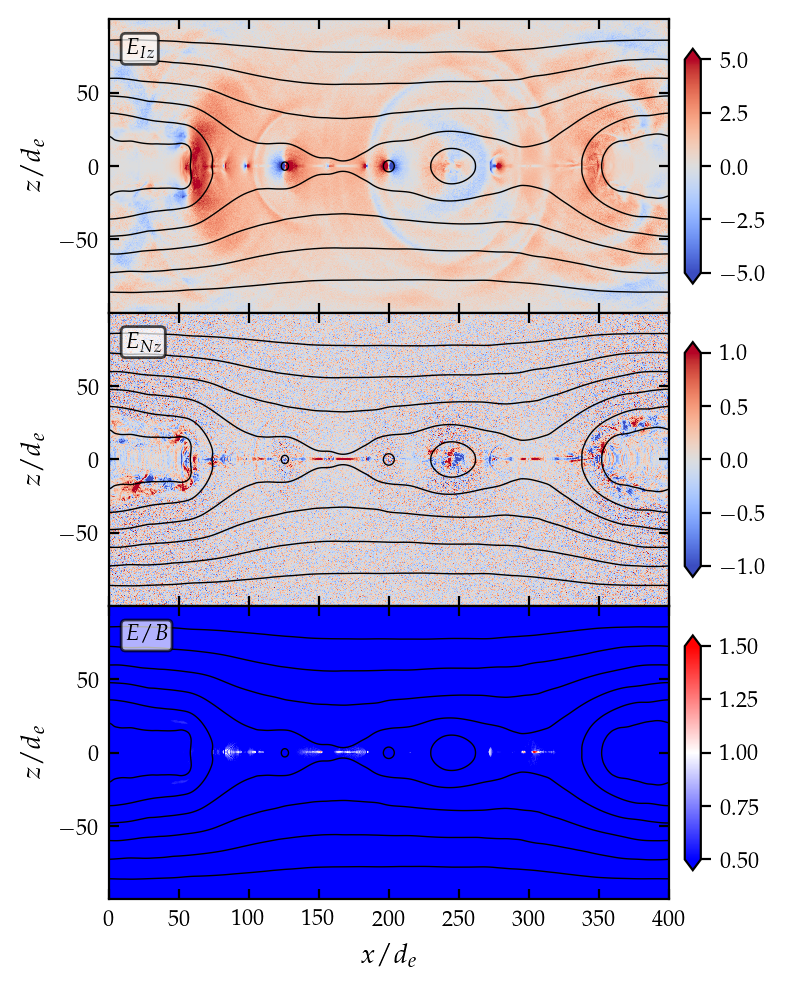

In [15]:
plot_electric_fields(4, show_plot=True)

# Particle spectra
Here, we plot time evolution of particle energy spectrum.

In [16]:
def read_spectrum(species, tindex):
    """Read energy spectrum for a HDF5 file

    Args:
        species: particle species, "electron", "ion" or others
        tframe: time frame
    """
    fname = "spectrum/T." + str(tindex) + "/spectrum_" + str(tindex) + ".h5"
    with h5py.File(fname, 'r') as fh:
        dset = fh["spectrum_" + species]
        fdata = dset[:, :, :, :]
    fspect = np.sum(np.sum(np.sum(fdata, axis=2), axis=1), axis=0)
    return fspect

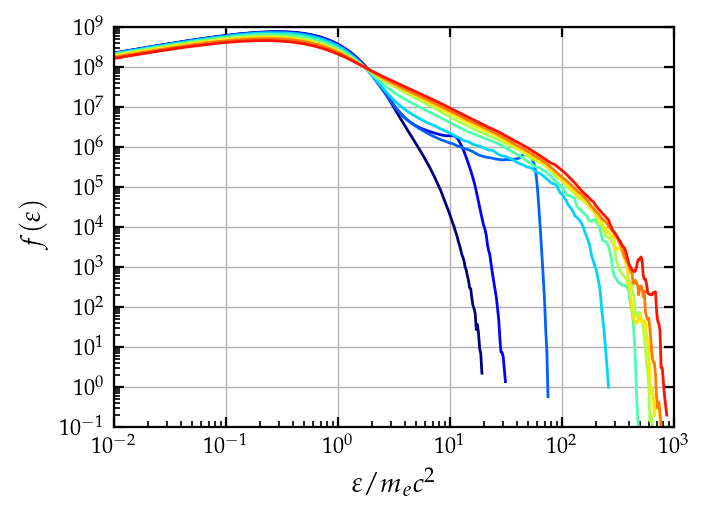

In [17]:
rect = [0.16, 0.16, 0.8, 0.8]
fig1 = plt.figure(figsize=[3.5, 2.5])
ax1 = fig1.add_axes(rect)

nframes = len(os.listdir("spectrum"))
spectrum_interval = int(vpic_info["spectrum_interval"])
emin = vpic_info["emin_spect"]
emax = vpic_info["emax_spect"]
nbins = int(vpic_info["nbins"])
ebins = np.geomspace(emin, emax, nbins+1)
debins = np.diff(ebins)
ebins_mid = 0.5 * (ebins[1:] + ebins[:-1])

for tframe in range(nframes):
    tindex = tframe * spectrum_interval
    fspect = read_spectrum("electron", tindex)[3:] / debins  # the first 3 are magnetic fields
    color = plt.cm.jet(tframe / nframes, 1)
    ax1.loglog(ebins_mid, fspect, linewidth=1, color=color, nonpositive="mask")

ax1.set_xlim([1E-2, 1E3])
ax1.set_ylim([1E-1, 1E9])
ax1.grid(linewidth=0.5)

ax1.tick_params(bottom=True, top=True, left=True, right=True)
ax1.tick_params(axis='x', which='minor', direction='in')
ax1.tick_params(axis='x', which='major', direction='in')
ax1.tick_params(axis='y', which='minor', direction='in')
ax1.tick_params(axis='y', which='major', direction='in')
ax1.set_xlabel(r'$\varepsilon/m_ec^2$', fontsize=10)
ax1.set_ylabel(r'$f(\varepsilon)$', fontsize=10)
ax1.tick_params(labelsize=8)
img_dir = './img/'
mkdir_p(img_dir)
fname = img_dir + "espect.pdf"
fig1.savefig(fname)

Even though the box is not large ($L_x=400d_e$), we can already see the formation of hard power-law tail with a power-law index of about -1.5.

# Tracer particles

For more information about particle tracking, please checkout [particle_tracking](https://github.com/xiaocanli/vpic_reconnection_tutorial/blob/main/particle_tracking.md). Here, we assume the simulation has generated tracer particles.

Initially, particle `tag` monotonically increases in the file. But as the simulation evolves, particles are mixed. That's why we need to sort particles afterwords. We can use a parallel sorting code https://github.com/xiaocanli/vpic-sorter to do that. In the run directory,
```sh
git clone https://github.com/xiaocanli/vpic-sorter/config
cp sort_particles.sh vpic-sorter
cd vpic-sorter
module load cpu cray-hdf5-parallel
make
```
which will generate a few executables. We will use `h5group-sorter` only here.

Please see the description there on how to compile the code. To run code, please follow `sort_particles.sh` in the current directory first. You need to copy `sort_particles.sh` to `vpic-sorter/config` first and modify the script for your simulation parameters.
```sh
cp sort_particles.sh YOUR_RUN_DIRECTORY/vpic-sorter/config
```
You can keep most of them as default and modify the following parameters if needed.
- `trace_particles`: if true, the code will trace `ntraj` particles after particles are sorted.
- `save_sorted_files`: if true, sorted particle data will be saved to files. We can set it to false when, for example, we only want to tracer particle trajectories.
- `run_name`: PIC simulation run name. Better to be unique.
- `runpath`: PIC simulation run path.
- `filepath`: the directory where the tracer data is so the code can find the tracer data.
- `particle`: electron or H. It can be other species if the PIC simulation includes them.
- `tstep_min`: minimum time step. Typically, 0.
- `tstep_max`: maximum time step. It can be determined automatically.
- `tstep_interval`: time step interval. It is the same as `tracer_interval` in the deck. It can also be determined automatically.
- `nsteps`: same as `nframes_per_tracer_file` in the deck. It can also be determined automatically.
- `mpi_size`: the number MPI processes for the sorting program.
- `ratio_emax`: maximum energy / starting energy. 1 means to find the highest energy particles. A higher value means to find lower-energy particles.
- `data_dir`: the directory where the trajectory data should be saved. If `trace_particles` is set true, the code will save the trajectory data to `data_dir`. The trajectory file will include `ntraj` tracer trajectories.

Check out more descriptions in `sort_particles.sh`. This procedure is quite inconvenient. The code was originally designed for sorting tens of millions or even billions of tracer particles. For most cases, we only have about 1 million tracer particles. You can use Python to sort the tracer particles instead. For example, you can read the tracer particle data as `numpy` arrays and sort the data along one certain axis.

By default, you can request an interactive node to run the code.
```sh
salloc --nodes 1 --qos interactive --time 04:00:00 --constraint cpu --account=m2407
module load cpu cray-hdf5-parallel
cd YOUR_RUN_DIRECTORY/vpic-sorter/config
./sort_particles.sh
```
which will `electron_tracer_qtag_sorted.h5p` files in `YOUR_RUN_DIRECTORY/tracer/tracer1/T.*` directories and `electrons_ntraj1000_1emax.h5p` in `data/sigmae100_bg00_400de`.
- `electron_tracer_qtag_sorted.h5p` is the tracers sorted by their tags. It is particularly useful for doing statistical analysis based on the tracers, as it is easy to select particles and apply masks. For example, you can select the particles > some threshold energy at the last time step using `numpy`, which will give you a mask of the particle tags. You can then use the mask to find out how these particles evolve at earlier time steps. We will give an example below.
- `electrons_ntraj1000_1emax.h5p` includes the trajectories of 1000 particles with the highest energies in the system. Each particle is a `group` in the HDF5 file. We will see one example below.

## Tracer trajectory
Here, we will plot a couple of trajectories in `electrons_ntraj1000_1emax.h5p`.

In [18]:
def plot_trajectory(fh, tag, iptl, absj, show_plot=True):
    """Plot particle trajectory

    fh: file handler
    tag: particle tag
    iptl: particle index
    absj: current density
    """
    img_dir = 'img/tracer_traj/'
    mkdir_p(img_dir)
    sname = "electron"

    print("Tracer particle: %d" % iptl)
    group = fh[tag]
    ptl = {}
    for dset_name in group:
        dset = group[dset_name]
        ptl[str(dset_name)] = dset[:]
    gamma = np.sqrt(1 + ptl["Ux"]**2 + ptl["Uy"]**2 + ptl["Uz"]**2)
    kene = gamma - 1
    x = ptl["dX"]
    y = ptl["dY"]
    z = ptl["dZ"]
    fig = plt.figure(figsize=[3.5, 3.0])
    gs = gridspec.GridSpec(3,
                           1,
                           wspace=0,
                           hspace=0.6,
                           top=0.96,
                           bottom=0.12,
                           left=0.15,
                           right=0.97)
    ax1 = plt.subplot(gs[0:2, 0])
    ax2 = plt.subplot(gs[2, 0])
    
    # rect = [0.15, 0.17, 0.82, 0.8]
    # ax1 = fig.add_axes(rect)
    xmin = 0
    xmax = vpic_info["Lx/de"]
    lx = xmax - xmin
    zmin = -0.5 * vpic_info["Lz/de"]
    zmax = 0.5 * vpic_info["Lz/de"]
    im1 = ax1.imshow(absj.T,
                     extent=[xmin, xmax, zmin, zmax],
                     norm = LogNorm(vmin=0.1, vmax=10),
                     cmap=plt.cm.binary, aspect='auto',
                     origin='lower',
                     interpolation='none')
    points = np.array([x, z]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    kene_mid = 0.5 * (kene[1:] + kene[:-1])

    # remove jumps across periodic boundary along X
    segments_new = []
    kene_mid_new = []
    nsteps = len(kene_mid)
    for i in range(nsteps):
        seg = segments[i, :, :]
        len_seg = math.sqrt((seg[0, 0] - seg[1, 0])**2 + (seg[0, 1] - seg[1, 1])**2)
        if len_seg < lx / 4:
            segments_new.append(seg)
            kene_mid_new.append(kene_mid[i])
    segments_new = np.asarray(segments_new)
    norm = plt.Normalize(kene.min(), kene.max())
    lc = LineCollection(segments_new, cmap='jet', norm=norm)
    lc.set_array(kene_mid_new)
    lc.set_linewidth(1)
    ax1.add_collection(lc)
    ax1.set_xlabel(r'$x/d_e$', fontsize=10)
    ax1.set_ylabel(r'$z/d_e$', fontsize=10)

    # t-energy plot
    dtwpe_tracer = vpic_info["dt*wpe"] * vpic_info["tracer_interval"]
    twpe = np.arange(len(x)) * dtwpe_tracer
    points = np.array([twpe, kene]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(kene.min(), kene.max())
    lc = LineCollection(segments, cmap='jet', norm=norm)
    lc.set_array(kene)
    lc.set_linewidth(1)
    ax2.add_collection(lc)
    # ax2.set_yscale("log")
    ax2.set_xlim([twpe.min(), twpe.max()])
    ax2.set_ylim([0, kene.max()])
    ax2.set_xlabel(r'$t\omega_{pe}$', fontsize=10)
    ax2.set_ylabel(r'$\gamma-1$', fontsize=10)

    for ax in [ax1, ax2]:
        ax.tick_params(bottom=True, top=True, left=True, right=True)
        ax.tick_params(axis='x', which='minor', direction='in')
        ax.tick_params(axis='x', which='major', direction='in')
        ax.tick_params(axis='y', which='minor', direction='in')
        ax.tick_params(axis='y', which='major', direction='in')
        ax.tick_params(labelsize=8)
    fname = img_dir + sname + "_tracer_" + str(iptl) + ".jpg"
    fig.savefig(fname, dpi=200)
    
    # if show_plot:
    #     plt.show()
    # else:
    #     plt.close()

In [19]:
# absJ as the background field
fields_interval = int(vpic_info["fields_interval"])
tframe = 4
tindex = fields_interval * tframe
absj = read_data("absj", tindex)

Total number of tracer trajectories: 1000
Tracer particle: 0


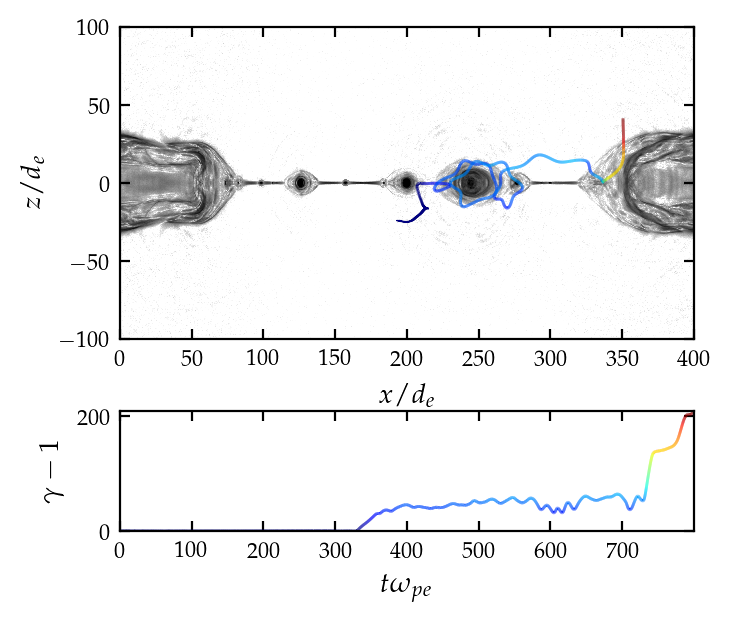

In [20]:
tracer_dir = "vpic-sorter/data/sigmae100_bg00_400de/"
fname = tracer_dir + "electrons_ntraj1000_1emax.h5p"
with h5py.File(fname, 'r') as fh:
    particle_tags = list(fh.keys())
    nptl = len(particle_tags)
    print("Total number of tracer trajectories: %d" % nptl)
    iptl = 0
    plot_trajectory(fh, particle_tags[iptl], iptl, absj)

## Compare parallel and perpendicular work

In [21]:
def compare_wpara_wperp(fh, tag, iptl, show_plot=True):
    """Compare parallel and perpendicular work

    fh: file handler
    tag: particle tag
    iptl: particle index
    """
    print("Tracer particle: %d" % iptl)
    group = fh[tag]
    ptl = {}
    for dset_name in group:
        dset = group[dset_name]
        ptl[str(dset_name)] = dset[:]
    gamma = np.sqrt(1 + ptl["Ux"]**2 + ptl["Uy"]**2 + ptl["Uz"]**2)
    dgamma = gamma - gamma[0]
    igamma = 1.0 / gamma
    vx = ptl["Ux"] * igamma
    vy = ptl["Uy"] * igamma
    vz = ptl["Uz"] * igamma
    ex = ptl["Ex"]
    ey = ptl["Ey"]
    ez = ptl["Ez"]
    bx = ptl["Bx"]
    by = ptl["By"]
    bz = ptl["Bz"]
    edotb = ex * bx + ey * by + ez * bz
    ib2 = 1.0 / (bx**2 + by**2 + bz**2)
    eparax = edotb * bx * ib2
    eparay = edotb * by * ib2
    eparaz = edotb * bz * ib2
    dtwpe_tracer = vpic_info["dt*wpe"] * vpic_info["tracer_interval"]
    wtot = np.cumsum(-(ex * vx + ey * vy + ez * vz)) * dtwpe_tracer
    # Work done by the parallel/perpendicular electric field
    wpara = np.cumsum(-(eparax * vx + eparay * vy +
                        eparaz * vz)) * dtwpe_tracer
    wperp = wtot - wpara
    twpe = np.arange(len(vx)) * dtwpe_tracer
    
    fig = plt.figure(figsize=[3.5, 2.5])
    rect = [0.15, 0.16, 0.82, 0.8]
    ax = fig.add_axes(rect)
    ax.plot(twpe, wpara, linewidth=1, label=r'$W_\parallel$')
    ax.plot(twpe, wperp, linewidth=1, label=r'$W_\perp$')
    ax.plot(twpe, dgamma, linewidth=1, label=r'$\Delta\gamma$')
    ax.set_xlim([twpe.min(), twpe.max()])
    ax.tick_params(bottom=True, top=True, left=True, right=True)
    ax.tick_params(axis='x', which='minor', direction='in')
    ax.tick_params(axis='x', which='major', direction='in')
    ax.tick_params(axis='y', which='minor', direction='in')
    ax.tick_params(axis='y', which='major', direction='in')
    ax.set_xlabel(r'$t\omega_{pe}$', fontsize=10)
    ax.set_ylabel('Energy change', fontsize=10)
    ax.tick_params(labelsize=8)
    ax.legend(loc=6,
              prop={'size': 8},
              ncol=1,
              shadow=False,
              fancybox=False,
              frameon=False)
    img_dir = 'img/wpara_wperp/'
    mkdir_p(img_dir)
    sname = "electron"
    fname = img_dir + sname + "_wpara_wperp_" + str(iptl) + ".pdf"
    fig.savefig(fname)
    
    if show_plot:
        plt.show()
    else:
        plt.close()

Total number of tracer trajectories: 1000
Tracer particle: 0


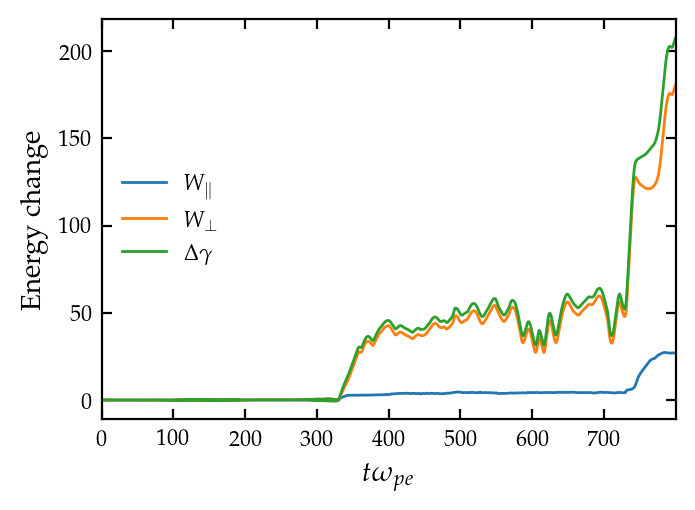

In [22]:
tracer_dir = "vpic-sorter/data/sigmae100_bg00_400de/"
fname = tracer_dir + "electrons_ntraj1000_1emax.h5p"
with h5py.File(fname, 'r') as fh:
    particle_tags = list(fh.keys())
    nptl = len(particle_tags)
    print("Total number of tracer trajectories: %d" % nptl)
    iptl = 0
    compare_wpara_wperp(fh, particle_tags[iptl], iptl)

## Check $E>B$ contribution
Here, we check the contributions of parallel electric field, perpendicular electric field, $E>B$ region, and $E\leq B$ region to the energy gains for each particle. You can see how we go through each tracer step to get the information. Following similar steps, you can check many other things about the tracers. For example, you can
- check how long tracers stay in the $E>B$ regions
- track how many tracers cross the $E>B$ regions at least once
- compare the final energies of the tracers crossing $E>B$ at least once and those not
 
If we dump the bulk flow velocity during VPIC simulation, we can also get the contributions from ideal and non-ideal electric field.

In [23]:
def get_elb_contribution():
    """
    """
    flist = os.listdir("tracer/tracer1")
    tframes = []
    for fname in flist:
        if "T." in fname:
            tframe = int(fname[2:])
            tframes.append(tframe)
    tframes = np.sort(tframes)
    tmax_file = tframes[-1]
    tracer_dir = "tracer/tracer1/"
    fname = tracer_dir + 'T.' + str(tmax_file) + '/electron_tracer_qtag_sorted.h5p'
    with h5py.File(fname, "r") as fh:
        nfiles_last_file = len(fh.keys())
        ntracers = len(fh["Step#" + str(tmax_file)]["Ux"])
    tracer_file_interval = int(vpic_info["tracer_file_interval"])
    tracer_interval = int(vpic_info["tracer_interval"])
    nsteps_tracer = (len(tframes) - 1) * tracer_file_interval + nfiles_last_file
    dke_epara = np.zeros(ntracers, dtype=np.float32)
    dke_eperp = np.zeros(ntracers, dtype=np.float32)
    dke_elb = np.zeros(ntracers, dtype=np.float32)  # Electric field <= magnetic field
    dke_egb = np.zeros(ntracers, dtype=np.float32)  # Electric field > magnetic field

    for tframe_file in (tframes):
        print("Time index for the file: %d" % tframe_file)
        fname = tracer_dir + "T." + str(tframe_file) + "/electron_tracer_qtag_sorted.h5p"
        with h5py.File(fname, 'r') as fh:
            nframes_in_file = len(fh)
            for iframe in range(nframes_in_file):
                tindex = iframe * tracer_interval + tframe_file
                gname = 'Step#' + str(tindex)
                if not gname in fh:  # only possible for the last tracer directory
                    break
                group = fh[gname]
                ptl = {}
                for dset_name in group:
                    ptl[dset_name] = group[dset_name][:]
                abse = np.sqrt(ptl["Ex"]**2 + ptl["Ey"]**2 + ptl["Ez"]**2)
                absb = np.sqrt(ptl["Bx"]**2 + ptl["By"]**2 + ptl["Bz"]**2)
                ib2 = 1.0 / absb**2
                gamma = np.sqrt(1 + ptl["Ux"]**2 + ptl["Uy"]**2 + ptl["Uz"]**2)
                edotb = ptl["Ex"] * ptl["Bx"] + ptl["Ey"] * ptl["By"] + ptl["Ez"] * ptl["Bz"]
                eparax = ptl["Bx"] * edotb * ib2
                eparay = ptl["By"] * edotb * ib2
                eparaz = ptl["Bz"] * edotb * ib2
                exi = (ptl["By"] * ptl["Uz"] - ptl["Bz"] * ptl["Uy"]) / gamma
                eyi = (ptl["Bz"] * ptl["Ux"] - ptl["Bx"] * ptl["Uz"]) / gamma
                ezi = (ptl["Bx"] * ptl["Uy"] - ptl["By"] * ptl["Ux"]) / gamma
                dke_epara += -(eparax * ptl["Ux"] + eparay * ptl["Uy"] + eparaz * ptl["Uz"]) / gamma
                dke_eperp += -((ptl["Ex"] - eparax) * ptl["Ux"] +
                               (ptl["Ey"] - eparay) * ptl["Uy"] +
                               (ptl["Ez"] - eparaz) * ptl["Uz"]) / gamma
                cond = abse > absb
                dke_egb[cond] += -(ptl["Ex"][cond] * ptl["Ux"][cond] +
                                   ptl["Ey"][cond] * ptl["Uy"][cond] +
                                   ptl["Ez"][cond] * ptl["Uz"][cond]) / gamma[cond]
                cond = abse <= absb
                dke_elb[cond] += -(ptl["Ex"][cond] * ptl["Ux"][cond] +
                                   ptl["Ey"][cond] * ptl["Uy"][cond] +
                                   ptl["Ez"][cond] * ptl["Uz"][cond]) / gamma[cond]
                if tindex == 0:
                    gamma0 = np.copy(gamma)
                elif tindex == nsteps_tracer * tracer_interval - 1:
                    gammaf = np.copy(gamma)
    gamma0.tofile('data/gamma0.dat')
    gammaf.tofile('data/gammaf.dat')
    dke_epara.tofile('data/dke_epara.dat')
    dke_eperp.tofile('data/dke_eperp.dat')
    dke_elb.tofile('data/dke_elb.dat')
    dke_egb.tofile('data/dke_egb.dat')

In [24]:
# get_elb_contribution()  # uncomment this to do the calculation

In [25]:
gamma0 = np.fromfile('data/gamma0.dat', dtype=np.float32)
gammaf = np.fromfile('data/gammaf.dat', dtype=np.float32)
dke_epara = np.fromfile('data/dke_epara.dat', dtype=np.float32)
dke_eperp = np.fromfile('data/dke_eperp.dat', dtype=np.float32)
dke_elb = np.fromfile('data/dke_elb.dat', dtype=np.float32)
dke_egb = np.fromfile('data/dke_egb.dat', dtype=np.float32)
dt_tracer = vpic_info["tracer_interval"] * vpic_info["dt*wpe"]
dke_epara *= dt_tracer
dke_eperp *= dt_tracer
dke_elb *= dt_tracer
dke_egb *= dt_tracer

In [26]:
def div0(a, b):
    """ ignore / 0, div0( [-1, 0, 1], 0 ) -> [0, 0, 0]
    From: http://stackoverflow.com/a/35696047/2561161
    """
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide(a, b)
        c[~np.isfinite(c)] = 0  # -inf inf NaN
    return c

In [27]:
ebins = np.logspace(0, 3, 101)
ebins_mid = 0.5 * (ebins[:-1] + ebins[1:])
fene, _ = np.histogram(gammaf - gamma0, bins=ebins)  # histogram of total energy gain
fdke_tot, _ = np.histogram(gammaf - gamma0, bins=ebins, weights=(gammaf - gamma0))  # total energy gains in each energy bin
fdke_epara, _ = np.histogram(gammaf - gamma0, bins=ebins, weights=dke_epara)  # energy gains due to the parallel electric field in each energy bin
fdke_eperp, _ = np.histogram(gammaf - gamma0, bins=ebins, weights=dke_eperp)  # energy gains due to the perpendicular electric field in each energy bin
fdke_elb, _ = np.histogram(gammaf - gamma0, bins=ebins, weights=dke_elb)  # energy gains in E<B regions in each energy bin
fdke_egb, _ = np.histogram(gammaf - gamma0, bins=ebins, weights=dke_egb)  # energy gains in E>B regions in each energy bin
fdke_tot = div0(fdke_tot, fene)
fdke_epara = div0(fdke_epara, fene)
fdke_eperp = div0(fdke_eperp, fene)
fdke_elb = div0(fdke_elb, fene)
fdke_egb = div0(fdke_egb, fene)

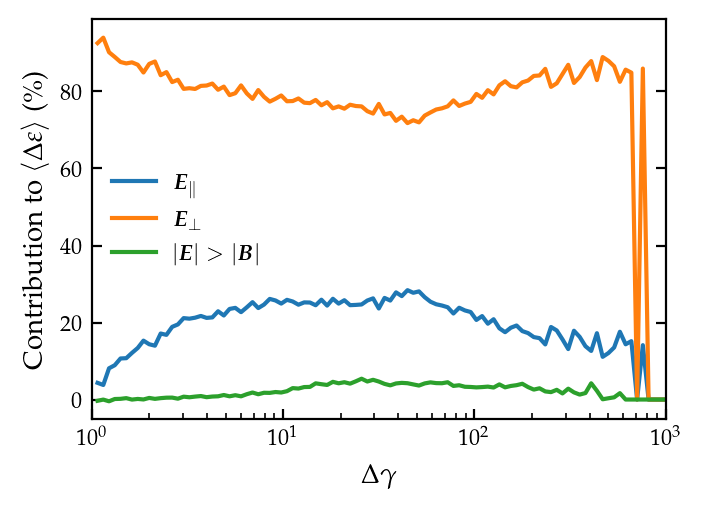

In [28]:
fig = plt.figure(figsize=[3.5, 2.5])
rect = [0.15, 0.16, 0.82, 0.8]
ax = fig.add_axes(rect)
ax.semilogx(ebins[1:], div0(fdke_epara * 100, fdke_tot), label=r'$\boldsymbol{E}_\parallel$')
ax.semilogx(ebins[1:], div0(fdke_eperp * 100, fdke_tot), label=r'$\boldsymbol{E}_\perp$')
ax.semilogx(ebins[1:], div0(fdke_egb * 100, fdke_tot), label=r'$|\boldsymbol{E}| > |\boldsymbol{B}|$')
# ax.plot([1, 1E3], [1, 1], color='k', linewidth=0.5, linestyle='--')
ax.set_xlim([1, 1E3])
# ax.set_ylim([0, 100])
ax.tick_params(axis='x', which='minor', direction='in')
ax.tick_params(axis='x', which='major', direction='in')
ax.tick_params(axis='y', which='minor', direction='in', right=True)
ax.tick_params(axis='y', which='major', direction='in', right=True)
ax.tick_params(labelsize=8)
ax.set_xlabel(r'$\Delta\gamma$', fontsize=10)
ax.set_ylabel(r'Contribution to $\left<\Delta\varepsilon\right>$ (\%)', fontsize=10)
ax.legend(loc=6,
          prop={'size': 8},
          ncol=1,
          shadow=False,
          fancybox=False,
          frameon=False)